In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"


from math import pi
import re
from tqdm import tqdm
from pathlib import Path
import pickle


from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit, pmap
from jax import random
import optax
import numpyro.distributions as dist


# jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c


import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, MN_POTENTIAL, NFW_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW
from odisseo.option_classes import DIFFRAX_BACKEND, DOPRI5, TSIT5, SEMIIMPLICITEULER, LEAPFROGMIDPOINT, REVERSIBLEHEUN


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})




/export/home/vgiusepp/miniconda3/envs/sbi_ds/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from functools import partial
import haiku as hk
from tensorflow_probability.substrates import jax as tfp
from jaxopt import Bisection
from jaxopt.linear_solve import solve_normal_cg

# tfp = tfp.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions


# This module is to store our implicit inverse functions
@partial(jax.custom_vjp, nondiff_argnums=(0,))
def root_bisection(f, params):
    """
    f: optimality fn with input arg (params, x)
    """
    bisec = Bisection(
        optimality_fun=f,
        lower=0.0,
        upper=1.0,
        check_bracket=False,
        maxiter=100,
        tol=1e-06,
    )
    return bisec.run(None, params).params


def root_bisection_fwd(f, params):
    z_star = root_bisection(f, params)
    return z_star, (params, z_star)


def root_bwd(f, res, z_star_bar):
    params, z_star = res
    _, vjp_a = jax.vjp(lambda p: f(z_star, p), params)
    _, vjp_z = jax.vjp(lambda z: f(z, params), z_star)
    return vjp_a(solve_normal_cg(lambda u: vjp_z(u)[0], -z_star_bar))


root_bisection.defvjp(root_bisection_fwd, root_bwd)


def make_inverse_fn(f):
    """Defines the inverse of the input function, and provides implicit gradients
    of the inverse.

    Args:
      f: callable of input shape (params, x)
    Retuns:
      inv_f: callable of with args (params, y)
    """

    def inv_fn(params, y):
        def optimality_fn(x, params):
            p, y = params
            return f(p, x) - y

        return root_bisection(optimality_fn, [params, y])

    return inv_fn

# Bijiector functions
class MixtureAffineSigmoidBijector(tfp.bijectors.Bijector):
    """
    Bijector based on a ramp function, and implemented using an implicit
    layer.
    This implementation is based on the Smooth Normalizing Flows described
    in: https://arxiv.org/abs/2110.00351
    """

    def __init__(self, a, b, c, p, name="MixtureAffineSigmoidBijector"):
        """
        Args:
          rho: function of x that defines a ramp function between 0 and 1
          a,b,c: scalar parameters of the coupling layer.
        """
        super(self.__class__, self).__init__(forward_min_event_ndims=0, name=name)
        self.a = a
        self.b = b
        self.c = c
        self.p = p

        def sigmoid(x, a, b, c):
            z = (jax.scipy.special.logit(x) + b) * a
            y = jax.nn.sigmoid(z) * (1 - c) + c * x
            return y

        # Rescaled bijection
        def f(params, x):
            a, b, c, p = params
            a_in, b_in = [0.0 - 1e-1, 1.0 + 1e-1]

            x = (x - a_in) / (b_in - a_in)
            x0 = (jnp.zeros_like(x) - a_in) / (b_in - a_in)
            x1 = (jnp.ones_like(x) - a_in) / (b_in - a_in)

            y = sigmoid(x, a, b, c)
            y0 = sigmoid(x0, a, b, c)
            y1 = sigmoid(x1, a, b, c)

            y = (y - y0) / (y1 - y0)
            return jnp.sum(p * (y * (1 - c) + c * x), axis=0)

        self.f = f

        # Inverse bijector
        self.inv_f = make_inverse_fn(f)

    def _forward(self, x):
        return jax.vmap(jax.vmap(self.f))([self.a, self.b, self.c, self.p], x)

    def _inverse(self, y):
        return jax.vmap(jax.vmap(self.inv_f))([self.a, self.b, self.c, self.p], y)

    def _forward_log_det_jacobian(self, x):
        def logdet_fn(x, a, b, c, p):
            g = jax.grad(self.f, argnums=1)([a, b, c, p], x)
            s, logdet = jnp.linalg.slogdet(jnp.atleast_2d(g))
            return s * logdet

        return jax.vmap(jax.vmap(logdet_fn))(x, self.a, self.b, self.c, self.p)


#Coupling layers
class AffineCoupling(hk.Module):
    def __init__(
        self, y, *args, layers=[128, 128], activation=jax.nn.leaky_relu, **kwargs
    ):
        """
        Args:
        y, conditioning variable
        layers, list of hidden layers
        activation, activation function for hidden layers
        """
        self.y = y
        self.layers = layers
        self.activation = activation
        super().__init__(*args, **kwargs)

    def __call__(self, x, output_units, **condition_kwargs):
        net = jnp.concatenate([x, self.y], axis=-1)
        for i, layer_size in enumerate(self.layers):
            net = self.activation(hk.Linear(layer_size, name="layer%d" % i)(net))

        shifter = tfb.Shift(hk.Linear(output_units)(net))
        scaler = tfb.Scale(jnp.clip(jnp.exp(hk.Linear(output_units)(net)), 1e-2, 1e2))
        return tfb.Chain([shifter, scaler])


class AffineSigmoidCoupling(hk.Module):
    """This is the coupling layer used in the Flow."""

    def __init__(
        self,
        y,
        *args,
        layers=[128, 128],
        n_components=32,
        activation=jax.nn.silu,
        **kwargs
    ):
        """
        Args:
        y, conditioning variable
        layers, list of hidden layers
        n_components, number of mixture components
        activation, activation function for hidden layers
        """
        self.y = y
        self.layers = layers
        self.n_components = n_components
        self.activation = activation
        super().__init__(*args, **kwargs)

    def __call__(self, x, output_units, **condition_kwargs):
        net = jnp.concatenate([x, self.y], axis=-1)
        for i, layer_size in enumerate(self.layers):
            net = self.activation(hk.Linear(layer_size, name="layer%d" % i)(net))

        log_a_bound = 4
        min_density_lower_bound = 1e-4
        n_components = self.n_components

        log_a = (
            jax.nn.tanh(hk.Linear(output_units * n_components, name="l3")(net))
            * log_a_bound
        )
        b = hk.Linear(output_units * n_components, name="l4")(net)
        c = min_density_lower_bound + jax.nn.sigmoid(
            hk.Linear(output_units * n_components, name="l5")(net)
        ) * (1 - min_density_lower_bound)
        p = hk.Linear(output_units * n_components, name="l6")(net)

        log_a = log_a.reshape(-1, output_units, n_components)
        b = b.reshape(-1, output_units, n_components)
        c = c.reshape(-1, output_units, n_components)
        p = p.reshape(-1, output_units, n_components)
        p = jax.nn.softmax(p)

        return MixtureAffineSigmoidBijector(jnp.exp(log_a), b, c, p)

# Normalizing flow model 
class ConditionalRealNVP(hk.Module):
    """A normalizing flow based on RealNVP using specified bijector functions."""

    def __init__(
        self, d, *args, n_layers=3, bijector_fn=AffineSigmoidCoupling, **kwargs
    ):
        """
        Args:
        d, dimensionality of the input
        n_layers, number of layers
        coupling_layer, list of coupling layers
        """
        self.d = d
        self.n_layer = n_layers
        self.bijector_fn = bijector_fn
        super().__init__(*args, **kwargs)

    def __call__(self, y):
        chain = tfb.Chain(
            [
                tfb.Permute(jnp.arange(self.d)[::-1])(
                    tfb.RealNVP(
                        self.d // 2, bijector_fn=self.bijector_fn(y, name="b%d" % i)
                    )
                )
                for i in range(self.n_layer)
            ]
        )

        nvp = tfd.TransformedDistribution(
            tfd.MultivariateNormalDiag(0.5 * jnp.ones(self.d), 0.05 * jnp.ones(self.d)),
            bijector=chain,
        )

        return nvp


2025-05-02 13:11:55.830286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746184315.849000 1316761 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746184315.854640 1316761 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746184315.869367 1316761 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746184315.869390 1316761 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746184315.869392 1316761 computation_placer.cc:177] computation placer alr

In [3]:
from typing import NamedTuple

#mimic the argument parser used in the sbi_bm_lens

class args_namedtuple(NamedTuple):

    #seed
    seed = 42

    #activation function
    activ_fun = "silu"

    #Normalizing flow
    nf = "affine"

    #score type
    score_type = "conditional"

    #sbi method
    sbi_method = "nle"

    #number of bijiector layers
    n_bijector_layers = 5 

    #number of coupling layers
    n_flow_layers = 3

    #number of observables
    n_observables = 32
    
    #number of parameters
    n_parameters = 5 #["t_end", "Mtot_plummer", "a_plummer", "M_NFW", "r_s"]

    #number of step
    total_steps = 1_000

    #batch size
    bacth_size = 64

    #score weight
    score_weight = 1


args = args_namedtuple()

master_seed = jax.random.PRNGKey(args.seed)

In [4]:
#### CREATE THE NDE #####

#activation  function
if args.activ_fun == "silu":
    activ_fun = jax.nn.silu
elif args.activ_fun == "sin":
    activ_func = jnp.sin

#score type
if args.sbi_method == "nle":
    score_type = "conditional"  #need to be pass to the model object (stochastic simulator)

#NF type, either smooth or affine
if args.nf == "smooth":
    if args.sbi_method == "npe":
        pass
    elif args.sbi_method == "nle":
        # how these qantities are comute (with dataset form prior)
        # scale_y = jnp.std(dataset_y, axis=0) / 0.07
        # shift_y = jnp.mean(dataset_y / scale_y, axis=0) - 0.5

        #just place holder, need to be calculated from the dataset for normalization 
        scale = jnp.ones(5)
        shift = jnp.ones(5)

        #NF ARCHITECTURE
        #128 neuron per layer
        bijector_layers = [128] * args.n_bijector_layers
        
        bijector = partial(
            AffineSigmoidCoupling,
            layers=bijector_layers,
            activation=activ_fun,
            n_components=16,
        )
        
        NF = partial(ConditionalRealNVP, 
                     n_layers=args.n_flow_layers, 
                     bijector_fn=bijector)

        class NDE(hk.Module):
            def __call__(self, y):
                nvp = NF(args.n_observables)(y)
                return tfd.TransformedDistribution(
                    nvp, tfb.Chain([tfb.Scale(scale), tfb.Shift(shift)])
                )
        
elif args.nf == "affine":
    bijector_layers = [128] * args.n_bijector_layers

    bijector = partial(AffineCoupling, layers=bijector_layers, activation=activ_fun)

    NF = partial(ConditionalRealNVP, n_layers=args.n_flow_layers, bijector_fn=bijector)

    class NDE(hk.Module):
        def __call__(self, y):
            return NF(args.n_observables)(y)
        
#FOR NPE NEED TO HAVE SMOOTH NORMALIZING FLOW
if args.nf == "affine" and args.sbi_method == "npe" and args.score_weight > 0:
    raise ValueError("NDE has to be smooth")

elif args.sbi_method == "nle":
    nf_log_prob = hk.without_apply_rng(
        hk.transform(lambda theta, y: NDE()(theta).log_prob(y).squeeze())
    )


print("done ✓")


done ✓


In [5]:
#This should be used to create the compress dataset, in this simplified case
#we are using it just to sample the prior, to be implemented the compression

class JaxCompressedSimulator:
    def __init__(self, ):

        # self.compressor = compressor #not used
        # self.params_compressor = params_compressor #not used
        # self.opt_state = opt_state #not used

        self.t_end = dist.Uniform(0.5, 10.0)
        self.Mtot_plummer = dist.Uniform(1e3, 1e5)
        self.a_plummer = dist.Uniform(0.1, 2.0)
        self.M_NFW = dist.Uniform(5e11, 1.5e12)
        self.r_s = dist.Uniform(1.0, 20.0)

        self.stack = [
            self.t_end,
            self.Mtot_plummer,
            self.a_plummer,
            self.M_NFW,
            self.r_s,
        ]

    def prior_sample(self, sample_shape, master_key):
        samples = []

        keys = jax.random.split(master_key, 6)

        for i, distribution in enumerate(self.stack):
            samples.append(distribution.sample(keys[i], sample_shape))

        return jnp.stack(samples).T

    def prior_log_prob(self, values):
        logp = 0

        for i, distribution in enumerate(self.stack):
            logp += distribution.log_prob(values[..., i])

        return logp

compressed_simulator = JaxCompressedSimulator()

In [6]:
######## INFERENCE ########
print("... inference")

params_init = nf_log_prob.init(
    master_seed, theta=0.5 * jnp.ones([1, 5]), y=0.5 * jnp.ones([1, args.n_observables])
)

prior_mean = jnp.mean(compressed_simulator.prior_sample((1000,), master_seed), axis=0)

nb_steps = args.total_steps - args.total_steps * 0.2

lr_scheduler = optax.exponential_decay(
    init_value=0.001,
    transition_steps=nb_steps // 50,
    decay_rate=0.9,
    end_value=1e-5,
)

... inference


In [7]:
class DeepSetsEncoder(hk.Module):
    def __init__(self, output_dim, hidden_dim: int = 128, name=None):
        super().__init__(name=name)
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

    def __call__(self, x):  # x: [N_particles, 6] or [B, N_particles, 6]
        mlp_phi = hk.nets.MLP([self.hidden_dim, self.hidden_dim, self.hidden_dim, self.output_dim])

        if x.ndim == 2:
            # Unbatched case: [N_particles, 6]
            x_phi = mlp_phi(x)  # [N_particles, output_dim]
            summary = jnp.mean(x_phi, axis=0)  # [output_dim]
        elif x.ndim == 3:
            # Batched case: [B, N_particles, 6]
            # Flatten for MLP: [B * N_particles, 6]
            B, N, D = x.shape
            x_flat = x.reshape(-1, D)
            x_phi_flat = mlp_phi(x_flat)  # [B * N_particles, output_dim]
            x_phi = x_phi_flat.reshape(B, N, self.output_dim)
            summary = jnp.mean(x_phi, axis=1)  # [B, output_dim]
        else:
            raise ValueError(f"Input must be of shape (N, D) or (B, N, D), got {x.shape}")

        return summary

In [8]:
#normalization function
        
def normalize(dataset, is_observable = False, dataset_name=None):
    if dataset_name is not None:
        mean = jnp.load(f'./params_compressor/normalization_for_compressor_{dataset_name}.npz')['mean']
        std = jnp.load(f'./params_compressor/normalization_for_compressor_{dataset_name}.npz')['std']
    if is_observable:
        # the shape in this case is (N, N_particles, 6)
        dataset_original_shape = dataset.shape
        normalized_dataset = dataset.reshape(-1, dataset.shape[-1])
        normalized_dataset = (normalized_dataset - mean)/ (std + 1e-8) 
        normalized_dataset = normalized_dataset.reshape(dataset_original_shape)
    else:
        normalized_dataset = (dataset - mean)/ (std + 1e-8) 

    return normalized_dataset

In [12]:
class SNLE:
    def __init__(self, NDE, init_params_nde, args):
        self.NDE = NDE
        self.params = init_params_nde
        self.dim = args.n_observables

    def log_prob_fn(self, params, theta, y):
        return self.NDE.apply(params, theta, y)

    def loss_nll_and_score(self, params, mu, batch, score, weight_score):
        lp, out = jax.vmap(
            jax.value_and_grad(
                lambda theta, x: self.log_prob_fn(
                    params, theta.reshape([1, 5]), x.reshape([1, self.dim])
                ).squeeze()
            )
        )(mu, batch)

        return (
            -jnp.mean(lp) + weight_score * jnp.sum((out - score) ** 2, axis=-1).mean()
        )

    def loss_nll(self, params, mu, batch, score, weight_score):
        lp = self.log_prob_fn(params, mu, batch)

        return -jnp.mean(lp)

    def train(
        self, data_path, learning_rate, total_steps=30_000, batch_size=128, score_weight=0
    ):
        #let's take only N<1000 
        #load data
        data_path = './data/data_NFW/'
        pattern = re.compile(r"chunk_(\d+)\.npz")  # capture any number of digits
        files = sorted(
            f for f in Path(data_path).glob("chunk_*.npz")
            if (m := pattern.fullmatch(f.name)) and int(m.group(1)) < 9500 and int(m.group(1)) > 0
        )
        theta_list, x_list, score_list = [], [], []

        for f in files:
            data = np.load(f)
            theta_list.append(data["theta"])
            x_list.append(data["x"])
            score_list.append(data["score"]) 


        dataset_theta = np.array(theta_list)
        dataset_theta = dataset_theta[~np.isnan(dataset_theta)]
        dataset_theta = dataset_theta.reshape(-1, 5)
        dataset_y = np.array(x_list)
        dataset_y = dataset_y[~np.isnan(dataset_y)]
        dataset_y = dataset_y.reshape(-1, 10_000, 6)
        
            

        if score_weight != 0:
            dataset_score = np.stack(score_list)
            dataset_score = dataset_score[~np.isnan(dataset_score)]
            dataset_score = dataset_score.reshape(-1, 5)
            loss_fn = self.loss_nll_and_score
        else:
            loss_fn = self.loss_nll
        
        #normalize the dataset
        dataset_theta = jnp.array(normalize(dataset_theta, dataset_name='theta'))
        dataset_y = jnp.array(normalize(dataset_y, is_observable=True, dataset_name='y'))
        if score_weight != 0:
            dataset_score = jnp.array(normalize(dataset_score, dataset_name='score'))


        #compress the observation y, first we need to load the parameters and the opt_state of the compressor pretrained

        compress_dim = self.dim #trained with this
        compressor = hk.transform_with_state(
                        lambda y: DeepSetsEncoder(compress_dim)(y)
                    )
        
        a_file = open(
            "./params_compressor/opt_state_SetNet_vmim.pkl",
            "rb",
        )
        opt_state_SetNet = pickle.load(a_file)

        a_file = open(
            "./params_compressor/params_nd_compressor_vmim.pkl",
            "rb",
        )
        parameters_compressor = pickle.load(a_file)
        #compressing like this is too much memory, let's do in the batches
        # dataset_y, _ = compressor.apply(
        #                         parameters_compressor, opt_state_SetNet, None, dataset_y
        #                     )
        # print('dataset y has been compressed')

        nb_simu = len(dataset_theta)

        print("nb of simulations used for training: ", nb_simu)

        params = self.params
        optimizer = optax.adam(learning_rate)
        opt_state = optimizer.init(params)

        @jax.jit
        def update(params, opt_state, mu, batch, score, weight_score):
            """Single SGD update step."""
            loss, grads = jax.value_and_grad(loss_fn)(
                params, mu, batch, score, weight_score
            )
            updates, new_opt_state = optimizer.update(grads, opt_state, params)
            new_params = optax.apply_updates(params, updates)

            return loss, new_params, new_opt_state

        print("... start training")

        batch_loss = []
        lr_scheduler_store = []
        pbar = tqdm(range(total_steps))

        for batch in pbar:
            inds = np.random.randint(0, nb_simu, batch_size)
            ex_theta = dataset_theta[inds]
            #compressing the y
            ex_y, _ = compressor.apply(
                                parameters_compressor, opt_state_SetNet, None, dataset_y[inds]
                            )
            if score_weight != 0:
                ex_score = dataset_score[inds]
            else:
                ex_score = None

            if not jnp.isnan(ex_y).any():
                l, params, opt_state = update(
                    params, opt_state, ex_theta, ex_y, ex_score, score_weight
                )

                batch_loss.append(l)
                pbar.set_description(f"loss {l:.3f}")

                if jnp.isnan(l):
                    break

        self.params = params
        self.loss = batch_loss

        print("done ✓")

    def sample(
        self,
        log_prob_prior,
        observation,
        init_point,
        key,
        num_results=3e2,
        num_burnin_steps=5e3,
        num_chains=12,
    ):
        print("... running hmc")

        @jax.vmap
        def unnormalized_log_prob(theta):
            prior = log_prob_prior(theta)

            # jax.debug.print('theta: {theta}, and its shape: {theta.shape}', theta=theta)
            # jax.debug.print('observation : {observation}, and its shape: {observation.shape}', observation=observation)

            likelihood = self.log_prob_fn(
                self.params,
                normalize(theta.reshape([1, 5]), dataset_name='theta'), #here we need to normalize 
                jnp.array(observation).reshape([1, self.dim]),
            )

            # jax.debug.print("likelihood: {likelihood}", likelihood=likelihood)
            # jax.debug.print("prior: {prior}", prior=prior)
            
            return likelihood + prior

        # Initialize the HMC transition kernel.
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
            tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_log_prob,
                num_leapfrog_steps=3,
                step_size=1e-2,
            ),
            num_adaptation_steps=int(num_burnin_steps * 0.8),
        )

        # Run the chain (with burn-in).
        # @jax.jit
        def run_chain():
            # Run the chain (with burn-in).
            samples, is_accepted = tfp.mcmc.sample_chain(
                num_results=num_results,
                num_burnin_steps=num_burnin_steps,
                current_state=jnp.array(init_point) * jnp.ones([num_chains, 5]),
                kernel=adaptive_hmc,
                trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
                seed=key,
            )
            # jax.debug.print('samples, {samples}', samples=samples)

            return samples, is_accepted

        samples_hmc, is_accepted_hmc = run_chain()
        sample_nd = samples_hmc[is_accepted_hmc]

        print("done ✓")

        return sample_nd

In [13]:
if args.sbi_method == "nle":
    inference = SNLE(NDE=nf_log_prob, init_params_nde=params_init, args=args)

In [14]:
inference.train(
    data_path="./data/data_NFW/",
    total_steps=args.total_steps,
    batch_size=args.bacth_size,
    score_weight=args.score_weight,
    # score_weight=0.,
    learning_rate=lr_scheduler,
)


nb of simulations used for training:  6891
... start training


loss -72.667: 100%|██████████| 1000/1000 [00:34<00:00, 29.26it/s]


done ✓


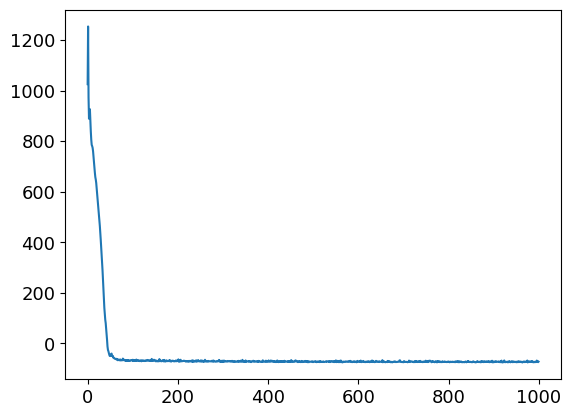

In [15]:
plt.plot(inference.loss)
# plt.ylim(-100, 50)
# plt.xlim(-1, 2000)
# plt.yscale('log')

In [16]:
theta_fid = jnp.load('./data/data_NFW/chunk_001000.npz')['theta']
y_fid = jnp.load('./data/data_NFW/chunk_001000.npz')['x']
normalized_theta_fid = normalize(theta_fid, dataset_name='theta')
normalized_y_fid = normalize(y_fid, is_observable=True, dataset_name='y')


# compress the y
compress_dim = args.n_observables #trained with this
compressor = hk.transform_with_state(
                lambda y: DeepSetsEncoder(compress_dim)(y)
            )

a_file = open(
    "./params_compressor/opt_state_SetNet_vmim.pkl",
    "rb",
)
opt_state_SetNet = pickle.load(a_file)

a_file = open(
    "./params_compressor/params_nd_compressor_vmim.pkl",
    "rb",
)
parameters_compressor = pickle.load(a_file)


m_data_comressed, _ = compressor.apply(
    parameters_compressor, opt_state_SetNet, None, normalized_y_fid
)

posterior_sample = inference.sample(
    log_prob_prior=compressed_simulator.prior_log_prob,
    observation=m_data_comressed,
    init_point=prior_mean,
    key=master_seed,
)

... running hmc
done ✓


In [17]:
posterior_sample

Array([[4.0624094e+00, 4.8656582e+04, 2.8318756e+00, 1.0048293e+12,
        1.4929296e+01],
       [1.1451960e+01, 4.9143812e+04, 6.9773912e-01, 1.0048293e+12,
        2.7244469e+01],
       [1.0284111e+01, 4.9046305e+04, 3.1914681e-01, 1.0048293e+12,
        7.2226357e+00],
       ...,
       [6.7847309e+00, 4.8873105e+04, 2.9593549e+00, 1.0048293e+12,
        9.4030123e+00],
       [5.8617625e+00, 4.9344477e+04, 9.9519551e-01, 1.0048293e+12,
        1.5699193e+01],
       [1.6259123e+00, 4.9017602e+04, 5.5080110e-01, 1.0048293e+12,
        2.2688425e+01]], dtype=float32)

In [40]:
theta_fid

array([1.8598862e+00, 9.9857094e+04, 1.3815263e-01, 7.2656958e+11,
       7.8090448e+00], dtype=float32)

In [41]:
normalized_theta_fid

array([-1.2537907 ,  1.7283808 , -1.6468372 , -0.9540455 , -0.48103794],
      dtype=float32)

In [18]:
import pandas as pd

df_samples = pd.DataFrame(posterior_sample, columns=["$t_{end}$", "$M_{plummer}$", "$a_{plummer}$", "$M_{NFW}$", "$r_s$"])
df_true = pd.DataFrame(normalized_theta_fid.reshape((1, 5)), columns=["$t_{end}$", "$M_{plummer}$", "$a_{plummer}$", "$M_{NFW}$", "$r_s$"])

<Axes: >

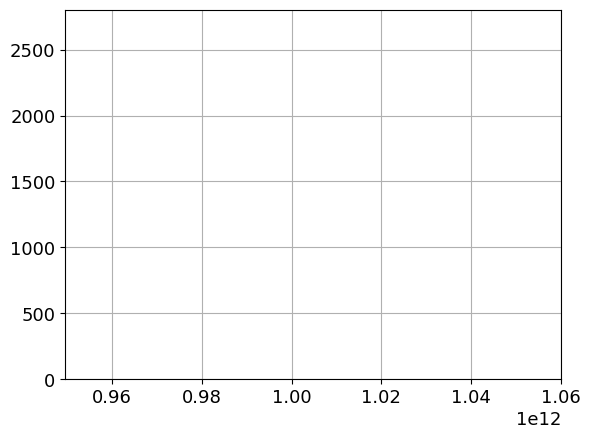

In [19]:
df_samples['$M_{NFW}$'].hist()

/export/home/vgiusepp/miniconda3/envs/sbi_ds/lib/python3.12/site-packages/chainconsumer/plotter.py:864: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(base.extents[p1])
/export/home/vgiusepp/miniconda3/envs/sbi_ds/lib/python3.12/site-packages/chainconsumer/plotter.py:865: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(base.extents[p2])
/export/home/vgiusepp/miniconda3/envs/sbi_ds/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/export/home/vgiusepp/miniconda3/envs/sbi_ds/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


IndexError: index 0 is out of bounds for axis 0 with size 0

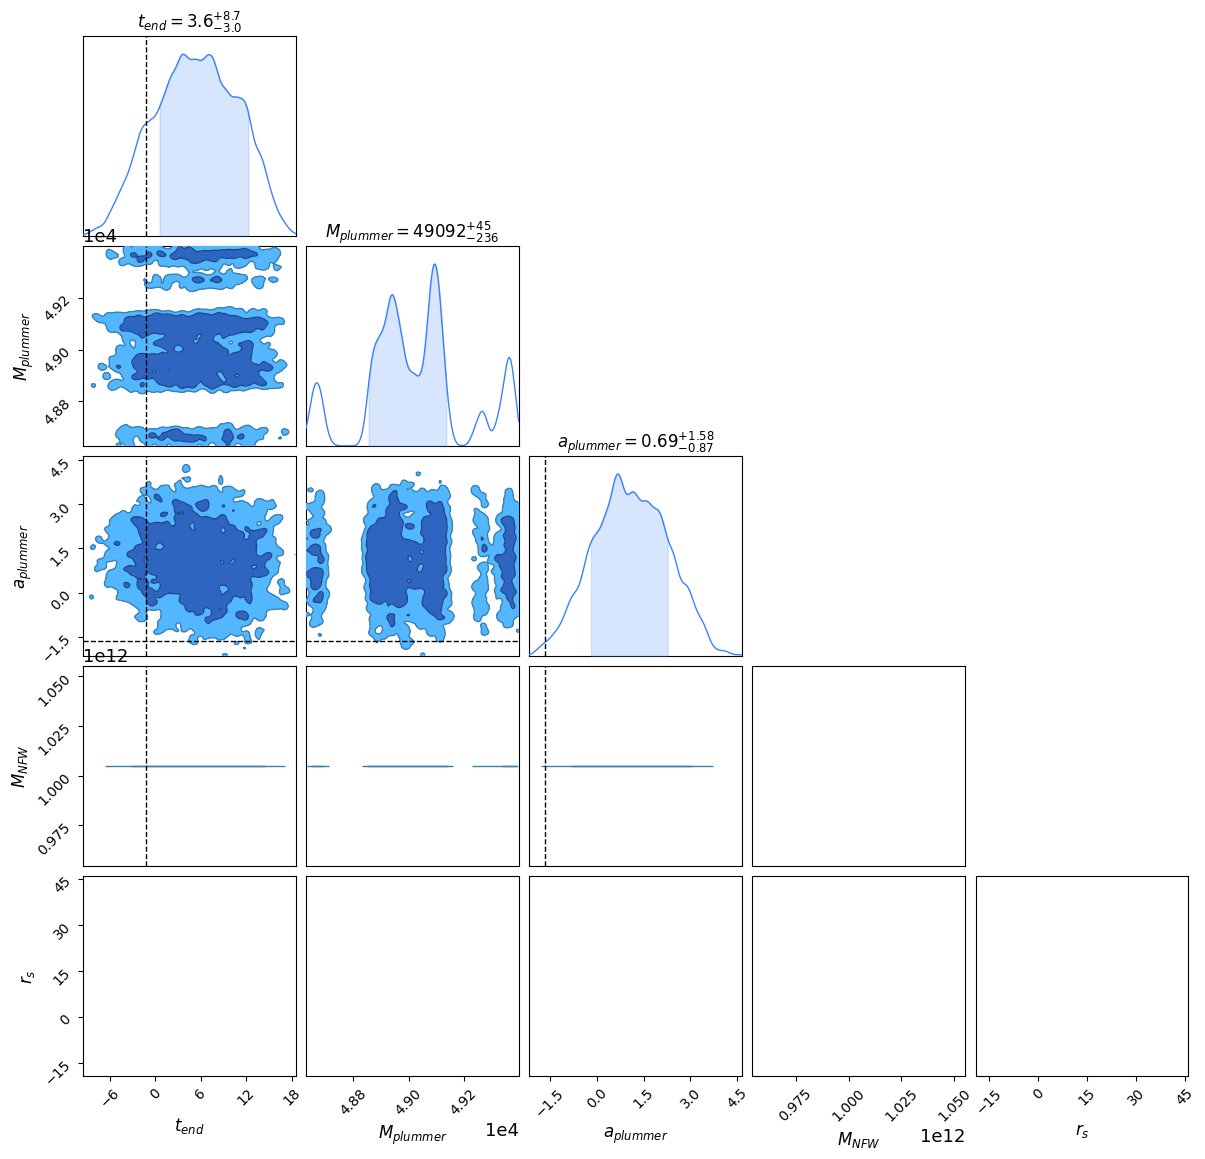

In [20]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth, PlotConfig


c = ChainConsumer()
c.add_chain(Chain(samples=df_samples, name='Posterior samples'))
c.add_truth(Truth(location=df_true.to_dict('records')[0], name='True' ),)
c.set_plot_config(PlotConfig(show_legend=True))
fig = c.plotter.plot()


In [31]:
data_path = './data/data_NFW/'
pattern = re.compile(r"chunk_(\d+)\.npz")  # capture any number of digits
files = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) < 9500 and int(m.group(1)) > 0
)
theta_list, x_list, score_list = [], [], []

for f in files:
    data = np.load(f)
    theta_list.append(data["theta"])
    x_list.append(data["x"])
    score_list.append(data["score"]) 


dataset_theta = np.array(theta_list)
dataset_theta = dataset_theta[~np.isnan(dataset_theta)]
dataset_theta = dataset_theta.reshape(-1, 5)
dataset_y = np.array(x_list)
dataset_y = dataset_y[~np.isnan(dataset_y)]
dataset_y = dataset_y.reshape(-1, 10_000, 6)
normalized_dataset_theta = normalize(dataset_theta, dataset_name='theta')   


(array([684., 691., 657., 708., 692., 716., 721., 694., 696., 680.]),
 array([ 1009.68920898, 10908.68945312, 20807.69140625, 30706.69140625,
        40605.69140625, 50504.69140625, 60403.69140625, 70302.6953125 ,
        80201.6953125 , 90100.6953125 , 99999.6953125 ]),
 <BarContainer object of 10 artists>)

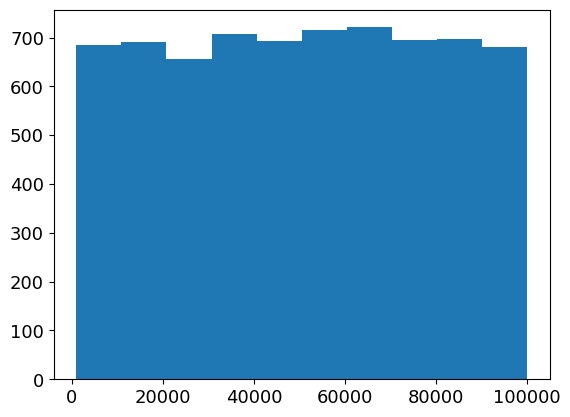

In [36]:
plt.hist(dataset_theta[:, 1])

(array([684., 691., 657., 708., 692., 716., 721., 694., 696., 680.]),
 array([-1.74592996, -1.39799762, -1.0500654 , -0.70213306, -0.35420075,
        -0.00626844,  0.34166387,  0.68959618,  1.03752851,  1.38546073,
         1.73339307]),
 <BarContainer object of 10 artists>)

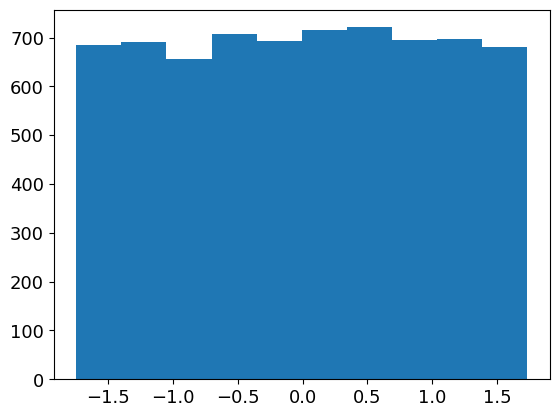

In [37]:
plt.hist(normalized_dataset_theta[:, 1])

In [ ]:
n